<a href="https://colab.research.google.com/github/msiplab/EicEngLabIV/blob/master/example02_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 実験Ⅳ－２　時系列データの分析

1. サンプルデータの読み込み
1. 平均 $\mu$ と分散 $\gamma_0$ の推定
1. 自己共分散関数 $\gamma_k$ と自己相関関数 $\rho_k$ の推定

新潟大学工学部工学科　電子情報通信プログラム 

## 準備

In [5]:
#!pip install bs4
!pip install japanize-matplotlib
%matplotlib inline

import warnings
warnings.simplefilter('ignore') #警告を無視（コメントアウト推奨）

from urllib import request
from bs4 import BeautifulSoup

import numpy as np
import pandas as pd
import pandas.tseries.offsets as offsets
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib #日本語化matplotlib
sns.set(font="IPAexGothic") #日本語フォント設定

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Webからの水位データの読み込み

新潟県河川防災情報システムより
http://doboku-bousai.pref.niigata.jp/kasen/index.html

河川ライブ映像 http://www.hrr.mlit.go.jp/shinano/live/map1.html# （小千谷市11番目）

以下のPythonライブラリを利用
- urllib
- bs4


In [6]:
# 水位観測所IDの設定
loc = '260' # 

# 解析期間の設定
dts = '2023040101' # 開始日時
dte = '2023042300' # 終了日時
interval = 1 # hour

# Webからの水位情報抽出
dts00 = pd.to_datetime(dts+'00')
dte00 = pd.to_datetime(dte+'00')
td = dte00 - dts00
durationinhours = int(td.total_seconds()/(3600))
t = [ [] for idx in range(durationinhours) ]
y = [ 0.0 for idx in range(durationinhours) ]
idt = dts00
idx = 0
while idt < dte00:
    # 水位抽出日時の設定
    strdt = idt.strftime('%Y%m%d%H%M')
    ts = pd.to_datetime(idt).tz_localize('Asia/Tokyo')

    # URLの設定
    url = 'http://doboku-bousai.pref.niigata.jp/kasen/servlet/bousaiweb.servletBousaiGraph?ga=4&gk=0&gn=0&gl=0&gw=0&go=0&omp=0&opn=0&spn=0&tvm=0&tsw=0&sv=3&dk=2&mp=0&no=0&fn=0&pg=6&sitept=0&unq=12062215494&nwg=0&tmg={0}&sn={1}&wsl=3&wl=1&rg=1&sy=gra_river&psn=0&=&nw=0&tm={0}&logflg=0'.format(strdt,loc)

    # 指定した時刻の水位情報抽出
    response = request.urlopen(url)
    soup = BeautifulSoup(response)
    response.close()
    if idt == dts00:
        strtitle = soup.title.text.strip()
    #print(soup.find('td', class_='tableHeaderCast').text.strip())
    strwaterlevel = soup.find('td', class_='tableHeaderItemCen').text.strip().replace('m','')
    try:
        waterlevel = float(strwaterlevel)
    except ValueError as ve:
        waterlevel = np.nan

    # リストへのデータ登録
    t[idx] = ts
    y[idx] = waterlevel

    # 時間を更新
    idx += 1
    idt += offsets.Hour(interval)


## 時系列データをpandas.DataFrameオブジェクトに変換

pandas ライブラリの DataFrame オブジェクトに変換

- t: 時刻
- y: データの値


In [7]:
df_timeseries= pd.DataFrame({'t': t, 'y': y})
display(df_timeseries)

,t,y
0,2023-04-01 01:00:00+09:00,43.61
1,2023-04-01 02:00:00+09:00,43.63
2,2023-04-01 03:00:00+09:00,43.66
3,2023-04-01 04:00:00+09:00,43.63
4,2023-04-01 05:00:00+09:00,43.56
...,...,...
522,2023-04-22 19:00:00+09:00,43.09
523,2023-04-22 20:00:00+09:00,43.06
524,2023-04-22 21:00:00+09:00,43.11
525,2023-04-22 22:00:00+09:00,42.94


## 時系列データをプロット

- y: 原系列
- y_fillna: 欠損個所を前の値で補間


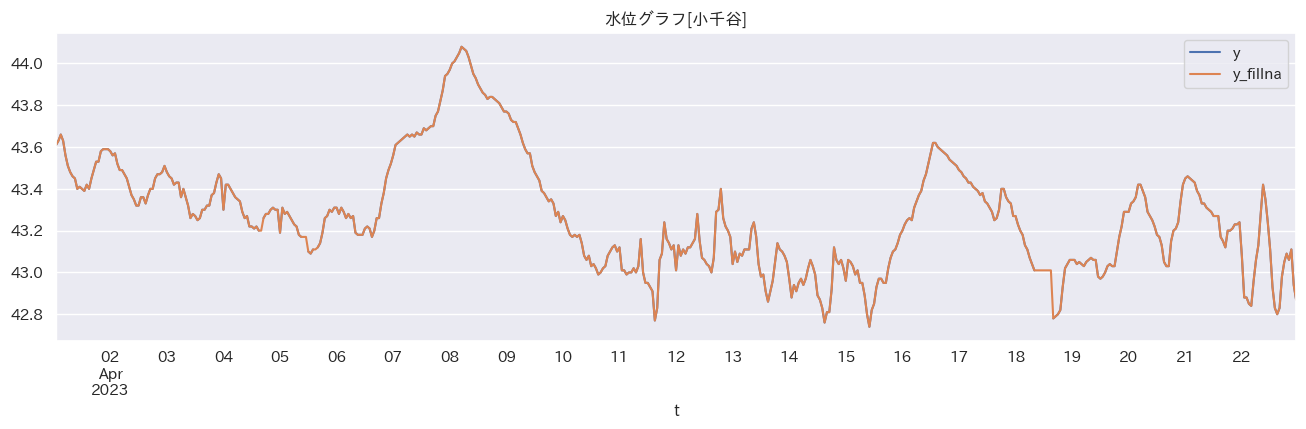

In [8]:
df_timeseries['y_fillna'] = df_timeseries['y'].fillna(method='ffill').astype(float)
ax = df_timeseries.plot(x='t', y=['y', 'y_fillna'], figsize=(16,4), title=strtitle)

ヒストグラムをプロット

Text(0.5, 1.0, '水位グラフ[小千谷]')

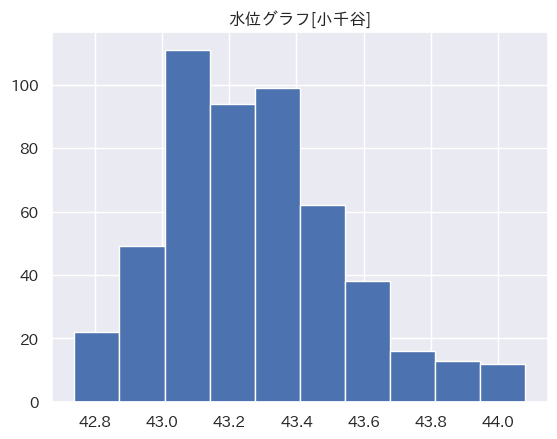

In [9]:
ax = df_timeseries.hist('y')
ax[0][0].set_title(strtitle)

## 平均 $\mu$ と分散 $\gamma_0$ の推定

- mean(): 標本平均を計算
- var(): 標本分散を計算

pandas.DataFrame オブジェクトのvar() メソッドのオプションで 

- ddof = 0 とすると N で割る最尤推定
- ddof = 1 とすると (N-1)で割る不偏推定 ※デフォルト

In [10]:
y_series = df_timeseries['y']
mu = y_series.mean()
gamma0 = y_series.var(ddof=1) 
print('平均 = {:f}, 分散 = {:f}'.format(mu,gamma0))

平均 = 43.276550, 分散 = 0.071007


## 自己共分散関数 $\gamma_k$ と自己相関関数 $\rho_k$ の推定

y_series は pandas.Series のオブジェクトとなっている。
pandas.Seriesオブジェクトは以下のメソッドを備える。

- cov() は共分散の不偏推定を計算
- corr() は相関の不偏推定を計算

※不偏推定から最尤推定への切替はできない


In [11]:
nlags = 40
for lag in range(nlags+1):
    gammak = y_series.cov(y_series.shift(lag))
    rhok = y_series.corr(y_series.shift(lag))
    print('γ{0:d} = {1:f}, ρ{0:d} = {2:f}'.format(lag,gammak,rhok))

γ0 = 0.071007, ρ0 = 1.000000
γ1 = 0.069732, ρ1 = 0.981865
γ2 = 0.067649, ρ2 = 0.954557
γ3 = 0.065190, ρ3 = 0.921670
γ4 = 0.062616, ρ4 = 0.887626
γ5 = 0.060428, ρ5 = 0.856301
γ6 = 0.058922, ρ6 = 0.832444
γ7 = 0.057677, ρ7 = 0.813601
γ8 = 0.057103, ρ8 = 0.803260
γ9 = 0.056532, ρ9 = 0.793627
γ10 = 0.055855, ρ10 = 0.782558
γ11 = 0.054842, ρ11 = 0.766439
γ12 = 0.053733, ρ12 = 0.748895
γ13 = 0.052371, ρ13 = 0.728496
γ14 = 0.050989, ρ14 = 0.708257
γ15 = 0.049550, ρ15 = 0.687440
γ16 = 0.048161, ρ16 = 0.666902
γ17 = 0.046716, ρ17 = 0.646508
γ18 = 0.045537, ρ18 = 0.631125
γ19 = 0.044598, ρ19 = 0.618216
γ20 = 0.043611, ρ20 = 0.604994
γ21 = 0.042434, ρ21 = 0.590119
γ22 = 0.041149, ρ22 = 0.573444
γ23 = 0.039654, ρ23 = 0.554874
γ24 = 0.038148, ρ24 = 0.533081
γ25 = 0.036027, ρ25 = 0.503003
γ26 = 0.033617, ρ26 = 0.469067
γ27 = 0.031204, ρ27 = 0.434808
γ28 = 0.028805, ρ28 = 0.400705
γ29 = 0.026488, ρ29 = 0.367759
γ30 = 0.024287, ρ30 = 0.336582
γ31 = 0.022192, ρ31 = 0.307135
γ32 = 0.020407, ρ32 = 0.2820

## 時系列解析ライブラリ

時系列解析には，statsmodelsライブラリも利用できる。

- acovf() は自己共分散関数を計算
- acf() は自己相関関数を計算

各メソッドのオプション unbiased = True で不偏推定，Falseで最尤推定となる．



In [17]:
import statsmodels.api as sm
from statsmodels.tsa import stattools

#欠損値がある場合は nan が含まれる．
#欠損個所を補間したデータを使わない場合は以下の行をコメントアウトする
y_series = df_timeseries['y_fillna']

print('自己共分散関数')
y_acovf = stattools.acovf(y_series,unbiased=True)
display(y_acovf)
print('自己相関関数')
y_acf = stattools.acf(y_series,adjusted=True)
display(y_acf)


自己共分散関数


array([ 7.04217781e-02,  6.89856346e-02,  6.69720067e-02,  6.46534200e-02,
        6.22539371e-02,  6.01326444e-02,  5.85084044e-02,  5.72082741e-02,
        5.63648591e-02,  5.55052808e-02,  5.46330100e-02,  5.34097533e-02,
        5.21494443e-02,  5.07467941e-02,  4.93133348e-02,  4.79037823e-02,
        4.65421514e-02,  4.51770711e-02,  4.41615106e-02,  4.32950730e-02,
        4.23529294e-02,  4.12929173e-02,  4.01498247e-02,  3.87754103e-02,
        3.72448499e-02,  3.51133713e-02,  3.27268768e-02,  3.03056219e-02,
        2.78548085e-02,  2.54406957e-02,  2.31290556e-02,  2.08719765e-02,
        1.89186639e-02,  1.70439960e-02,  1.51839777e-02,  1.31837472e-02,
        1.12242489e-02,  9.34783159e-03,  7.55478565e-03,  5.86004100e-03,
        4.35962728e-03,  2.98753351e-03,  1.93408218e-03,  1.08464571e-03,
        4.66947917e-04, -8.91605707e-05, -5.67034823e-04, -9.88804867e-04,
       -1.62190958e-03, -2.51186246e-03, -3.63446289e-03, -4.86677751e-03,
       -6.14037109e-03, -

自己相関関数


array([1.        , 0.97960654, 0.95101272, 0.91808844, 0.88401541,
       0.85389273, 0.83082827, 0.81236623, 0.80038961, 0.78818346,
       0.77579708, 0.75842665, 0.74053007, 0.72061222, 0.70025688,
       0.68024102, 0.66090565, 0.64152131, 0.62710019, 0.61479665,
       0.60141806, 0.58636573, 0.57013364, 0.55061675, 0.52888255,
       0.49861523, 0.46472665, 0.43034446])

## 原系列のコレログラムの表示

自己相関のグラフをコレログラムとよぶ。コレログラムは次のコマンドで表示できる。

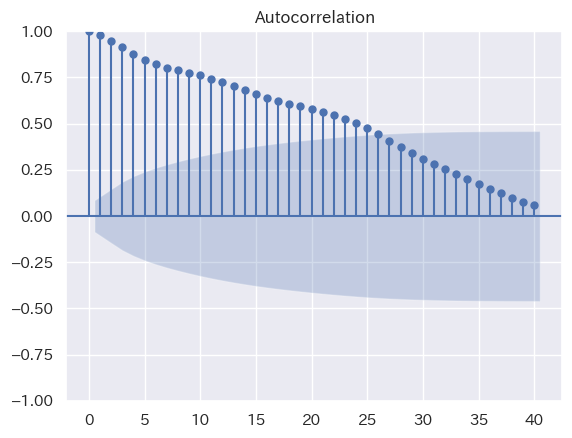

In [18]:
fig = sm.graphics.tsa.plot_acf(y_series,lags=nlags)

## 階差系列の分析

ひとつ前の値との差分をとった系列を階差系列とよぶ。

$\Delta y_n = y_{n} - y_{n-1}$


,t,y,y_fillna,y_diff
0,2023-04-01 01:00:00+09:00,43.61,43.61,NaN
1,2023-04-01 02:00:00+09:00,43.63,43.63,0.02
2,2023-04-01 03:00:00+09:00,43.66,43.66,0.03
3,2023-04-01 04:00:00+09:00,43.63,43.63,-0.03
4,2023-04-01 05:00:00+09:00,43.56,43.56,-0.07
...,...,...,...,...
522,2023-04-22 19:00:00+09:00,43.09,43.09,0.04
523,2023-04-22 20:00:00+09:00,43.06,43.06,-0.03
524,2023-04-22 21:00:00+09:00,43.11,43.11,0.05
525,2023-04-22 22:00:00+09:00,42.94,42.94,-0.17


<Axes: title={'center': '水位グラフ[小千谷]の階差系列'}, xlabel='t'>

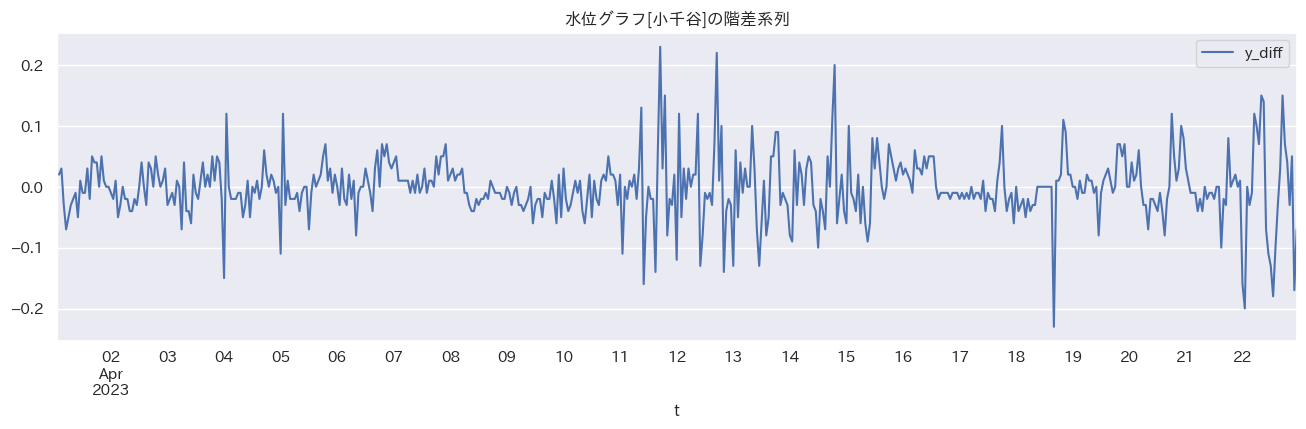

In [14]:
# 欠損データの補間を行わない場合
#df_timeseries['y_diff'] = df_timeseries['y'].diff()
# 欠損データを補間を行う場合
df_timeseries['y_diff'] = df_timeseries['y_fillna'].diff()
display(df_timeseries)
df_timeseries.plot(x='t', y='y_diff', figsize=(16,4), title='{}の階差系列'.format(strtitle))



ヒストグラムをプロット


Text(0.5, 1.0, '水位グラフ[小千谷]（階差）')

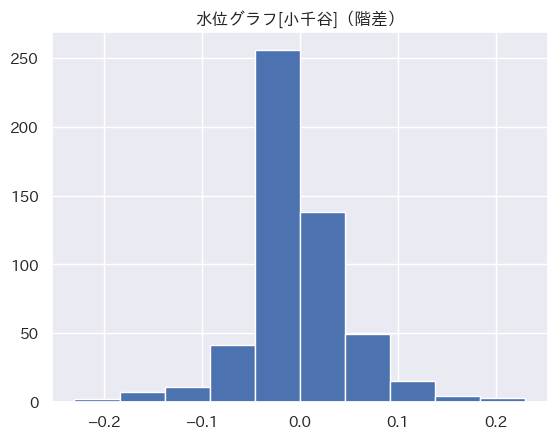

In [15]:
ax = df_timeseries.hist('y_diff')
ax[0][0].set_title(strtitle+'（階差）')

原系列 $y_n$ と階差系列 $\Delta y_n$ のCSVへの出力

In [16]:
#df_timeseries.to_csv('./data/sample02_03.csv',index=False)